In [1]:
# import sys
# import gymnasium as gym
# sys.modules["gym"] = gym
import gym
gym.__version__

'0.21.0'

In [2]:
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import distance

In [4]:
import gnwrapper

In [5]:
env_id = "CarRacing-v0"
NUM_CPU = 4  # Number0of processes to use

In [6]:
from utils import CarRacingGroundTruthObsWrapper
def wrapper(env):
    env = CarRacingGroundTruthObsWrapper(env) 
    env = gnwrapper.Animation(env)
    return env

def make_env(env_id):
    def _init():
        env = gym.make(env_id)
        env = wrapper(env)
        return env
    
    return _init

In [7]:
expert = PPO.load("./policy/ppo_CarRacing_expert-1kk.zip", print_system_info=True)

== CURRENT SYSTEM INFO ==
- OS: Linux-5.15.0-60-generic-x86_64-with-glibc2.35 # 66-Ubuntu SMP Fri Jan 20 14:29:49 UTC 2023
- Python: 3.10.6
- Stable-Baselines3: 1.7.0
- PyTorch: 1.13.1+cu117
- GPU Enabled: True
- Numpy: 1.24.1
- Gym: 0.21.0

== SAVED MODEL SYSTEM INFO ==
- OS: Linux-5.15.0-58-generic-x86_64-with-glibc2.35 # 64-Ubuntu SMP Thu Jan 5 11:43:13 UTC 2023
- Python: 3.10.6
- Stable-Baselines3: 1.7.0
- PyTorch: 1.13.1+cu117
- GPU Enabled: True
- Numpy: 1.24.1
- Gym: 0.21.0



In [13]:
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
import dataclasses
from stable_baselines3.common.vec_env import VecTransposeImage

NUM_EPISODES = 50
env = gym.make(env_id)
env = gym.wrappers.gray_scale_observation.GrayScaleObservation(env, keep_dim=True)
env = RolloutInfoWrapper(env) # Wrapper to save origin obs
env = wrapper(env) # Wrapper Obs
env = DummyVecEnv([lambda: env]) # Vectorized env

rng = np.random.default_rng()
rollouts = rollout.rollout(
    expert,
    env,
    rollout.make_sample_until(min_timesteps=None, min_episodes=NUM_EPISODES),
    rng = rng,
    unwrap = True
)

transitions = rollout.flatten_trajectories(rollouts)

Track generation: 1023..1283 -> 260-tiles track
Track generation: 1155..1448 -> 293-tiles track
Track generation: 1035..1298 -> 263-tiles track
Track generation: 1090..1366 -> 276-tiles track
Track generation: 964..1209 -> 245-tiles track
Track generation: 1196..1499 -> 303-tiles track
Track generation: 1159..1452 -> 293-tiles track
Track generation: 1263..1583 -> 320-tiles track
Track generation: 1236..1549 -> 313-tiles track
Track generation: 999..1263 -> 264-tiles track
Track generation: 1115..1399 -> 284-tiles track
Track generation: 1192..1494 -> 302-tiles track
Track generation: 1049..1315 -> 266-tiles track
Track generation: 1268..1589 -> 321-tiles track
Track generation: 1119..1403 -> 284-tiles track
Track generation: 1279..1603 -> 324-tiles track
Track generation: 1229..1540 -> 311-tiles track
Track generation: 1137..1425 -> 288-tiles track
Track generation: 1211..1518 -> 307-tiles track
Track generation: 1179..1478 -> 299-tiles track
Track generation: 1144..1441 -> 297-tiles 

In [14]:
print(
    f"""The `rollout` function generated a list of {len(rollouts)} {type(rollouts[0])}.
After flattening, this list is turned into a {type(transitions)} object containing {len(transitions)} transitions.
The transitions object contains arrays for: {', '.join(transitions.__dict__.keys())}."
"""
)

The `rollout` function generated a list of 50 <class 'imitation.data.types.TrajectoryWithRew'>.
After flattening, this list is turned into a <class 'imitation.data.types.Transitions'> object containing 45510 transitions.
The transitions object contains arrays for: obs, acts, infos, next_obs, dones."



In [15]:
from imitation.algorithms import bc
from stable_baselines3.common.policies import ActorCriticCnnPolicy

env = gym.make(env_id)
env = gnwrapper.Animation(env)
bc_trainer = bc.BC(
    observation_space=env.observation_space,
    action_space=env.action_space,
    demonstrations=transitions,
    rng=rng,
    batch_size=1024
    # policy=MultiInputActorCriticPolicy(
                             # observation_space=env.observation_space,
                             # action_space=env.action_space,
                             # lr_schedule=lambda _: torch.finfo(torch.float32).max,
                             # net_arch=[64, 64]
                             # )
)

In [18]:
bc_trainer.train(n_epochs=100)

0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 1024     |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -0.00132 |
|    entropy        | 1.32     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 80.4     |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.464    |
|    samples_so_far | 1024     |
--------------------------------


43batch [00:02, 18.97batch/s]
86batch [00:04, 20.47batch/s]
132batch [00:06, 19.36batch/s][A
175batch [00:08, 20.77batch/s]
219batch [00:11, 20.67batch/s]
263batch [00:13, 20.99batch/s]
307batch [00:15, 20.65batch/s]
350batch [00:17, 20.45batch/s]
394batch [00:19, 19.61batch/s]
438batch [00:22, 19.73batch/s]
482batch [00:24, 19.68batch/s]
499batch [00:25, 19.71batch/s]

--------------------------------
| batch_size        | 1024     |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | -0.00132 |
|    entropy        | 1.32     |
|    epoch          | 11       |
|    l2_loss        | 0        |
|    l2_norm        | 80.3     |
|    loss           | 1.34     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.479    |
|    samples_so_far | 513024   |
--------------------------------


526batch [00:26, 20.95batch/s]
571batch [00:28, 20.64batch/s]
615batch [00:31, 19.74batch/s]
660batch [00:33, 20.73batch/s]
703batch [00:35, 18.54batch/s]
746batch [00:37, 21.03batch/s]
791batch [00:39, 20.16batch/s]
835batch [00:42, 20.28batch/s]
880batch [00:44, 20.98batch/s]
922batch [00:46, 21.23batch/s]
967batch [00:48, 20.89batch/s]
1000batch [00:50, 20.39batch/s][A

--------------------------------
| batch_size        | 1024     |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | -0.00132 |
|    entropy        | 1.32     |
|    epoch          | 22       |
|    l2_loss        | 0        |
|    l2_norm        | 80.3     |
|    loss           | 1.22     |
|    neglogp        | 1.22     |
|    prob_true_act  | 0.484    |
|    samples_so_far | 1025024  |
--------------------------------


1012batch [00:50, 20.71batch/s]
1056batch [00:52, 21.22batch/s]
1098batch [00:54, 20.88batch/s]
1143batch [00:57, 21.42batch/s]
1188batch [00:59, 20.49batch/s]
1230batch [01:01, 21.27batch/s]
1274batch [01:03, 20.17batch/s]
1319batch [01:05, 21.08batch/s]
1364batch [01:07, 18.50batch/s]
1406batch [01:09, 21.23batch/s]
1451batch [01:12, 20.93batch/s]
1496batch [01:14, 20.99batch/s]
1499batch [01:14, 20.40batch/s]

--------------------------------
| batch_size        | 1024     |
| bc/               |          |
|    batch          | 1500     |
|    ent_loss       | -0.00132 |
|    entropy        | 1.32     |
|    epoch          | 34       |
|    l2_loss        | 0        |
|    l2_norm        | 80.3     |
|    loss           | 1.36     |
|    neglogp        | 1.36     |
|    prob_true_act  | 0.49     |
|    samples_so_far | 1537024  |
--------------------------------


1539batch [01:16, 21.09batch/s]
1584batch [01:18, 21.44batch/s]
1626batch [01:20, 20.53batch/s]
1672batch [01:23, 21.14batch/s]
1714batch [01:25, 21.34batch/s]
1759batch [01:27, 20.79batch/s]
1804batch [01:29, 21.27batch/s]
1846batch [01:31, 19.49batch/s]
1891batch [01:33, 21.39batch/s]
1936batch [01:35, 19.13batch/s]
1978batch [01:37, 21.50batch/s]
1999batch [01:38, 20.68batch/s]

--------------------------------
| batch_size        | 1024     |
| bc/               |          |
|    batch          | 2000     |
|    ent_loss       | -0.00131 |
|    entropy        | 1.31     |
|    epoch          | 45       |
|    l2_loss        | 0        |
|    l2_norm        | 80.3     |
|    loss           | 1.38     |
|    neglogp        | 1.38     |
|    prob_true_act  | 0.486    |
|    samples_so_far | 2049024  |
--------------------------------


2023batch [01:40, 19.12batch/s]
2067batch [01:42, 20.22batch/s]
2110batch [01:44, 20.17batch/s]
2156batch [01:47, 19.78batch/s]
2200batch [01:49, 19.86batch/s]
2243batch [01:51, 18.84batch/s]
2288batch [01:53, 20.62batch/s]
2332batch [01:56, 20.84batch/s]
2376batch [01:58, 20.60batch/s]
2419batch [02:00, 19.19batch/s]
2463batch [02:02, 20.24batch/s]
2500batch [02:04, 20.21batch/s]

--------------------------------
| batch_size        | 1024     |
| bc/               |          |
|    batch          | 2500     |
|    ent_loss       | -0.00132 |
|    entropy        | 1.32     |
|    epoch          | 56       |
|    l2_loss        | 0        |
|    l2_norm        | 80.3     |
|    loss           | 1.44     |
|    neglogp        | 1.44     |
|    prob_true_act  | 0.483    |
|    samples_so_far | 2561024  |
--------------------------------


2508batch [02:04, 18.65batch/s]
2550batch [02:07, 21.15batch/s]
2595batch [02:09, 20.24batch/s]
2639batch [02:11, 20.05batch/s]
2683batch [02:13, 20.54batch/s]
2726batch [02:15, 20.65batch/s]
2770batch [02:18, 20.97batch/s]
2816batch [02:20, 20.08batch/s]
2859batch [02:22, 19.63batch/s]
2904batch [02:25, 20.04batch/s]
2948batch [02:27, 20.42batch/s]
2991batch [02:29, 20.29batch/s]
3000batch [02:30, 18.72batch/s]

--------------------------------
| batch_size        | 1024     |
| bc/               |          |
|    batch          | 3000     |
|    ent_loss       | -0.00132 |
|    entropy        | 1.32     |
|    epoch          | 68       |
|    l2_loss        | 0        |
|    l2_norm        | 80.3     |
|    loss           | 1.38     |
|    neglogp        | 1.38     |
|    prob_true_act  | 0.472    |
|    samples_so_far | 3073024  |
--------------------------------


3035batch [02:31, 18.36batch/s]
3080batch [02:34, 19.43batch/s]
3124batch [02:36, 20.80batch/s]
3166batch [02:38, 20.44batch/s]
3210batch [02:40, 20.39batch/s]
3255batch [02:43, 20.48batch/s]
3300batch [02:45, 20.64batch/s]
3344batch [02:47, 21.02batch/s]
3386batch [02:49, 20.44batch/s]
3432batch [02:51, 19.80batch/s]
3476batch [02:54, 19.79batch/s]
3500batch [02:55, 20.22batch/s]

--------------------------------
| batch_size        | 1024     |
| bc/               |          |
|    batch          | 3500     |
|    ent_loss       | -0.00132 |
|    entropy        | 1.32     |
|    epoch          | 79       |
|    l2_loss        | 0        |
|    l2_norm        | 80.3     |
|    loss           | 1.4      |
|    neglogp        | 1.4      |
|    prob_true_act  | 0.477    |
|    samples_so_far | 3585024  |
--------------------------------


3518batch [02:56, 21.00batch/s]
3562batch [02:58, 20.66batch/s]
3608batch [03:00, 20.20batch/s]
3650batch [03:03, 19.26batch/s]
3696batch [03:05, 20.74batch/s]
3740batch [03:07, 18.32batch/s]
3782batch [03:09, 19.70batch/s]
3827batch [03:12, 18.89batch/s]
3871batch [03:14, 19.91batch/s]
3916batch [03:16, 21.05batch/s]
3958batch [03:18, 20.87batch/s]
3999batch [03:20, 20.75batch/s]

--------------------------------
| batch_size        | 1024     |
| bc/               |          |
|    batch          | 4000     |
|    ent_loss       | -0.00132 |
|    entropy        | 1.32     |
|    epoch          | 90       |
|    l2_loss        | 0        |
|    l2_norm        | 80.3     |
|    loss           | 1.33     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.485    |
|    samples_so_far | 4097024  |
--------------------------------


4002batch [03:20, 20.57batch/s]
4047batch [03:23, 16.20batch/s]
4092batch [03:25, 19.89batch/s]
4136batch [03:27, 19.99batch/s]
4179batch [03:29, 20.91batch/s]
4223batch [03:32, 19.97batch/s]
4268batch [03:34, 20.23batch/s]
4310batch [03:36, 17.98batch/s]
4355batch [03:38, 20.66batch/s]
4398batch [03:41, 20.24batch/s]
4400batch [03:41, 19.89batch/s]


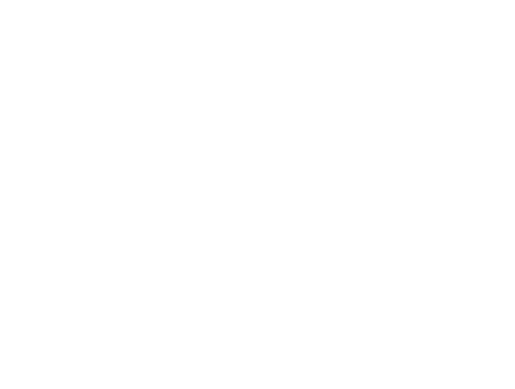

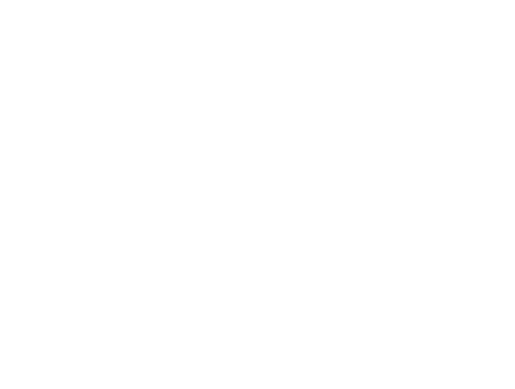

In [23]:
obs = env.reset()
while True:
    action, _states = bc_trainer.policy.predict(obs.copy())
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
        break
    
env.close()

In [21]:
from stable_baselines3.common.evaluation import evaluate_policy

In [22]:
reward, _ = evaluate_policy(bc_trainer.policy, env, 5)
print(f"BC reward: {reward}")

/home/vlad1slav/Diploma/rl-venv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Track generation: 1196..1499 -> 303-tiles track
Track generation: 1108..1389 -> 281-tiles track
Track generation: 1139..1428 -> 289-tiles track
Track generation: 1090..1373 -> 283-tiles track
Track generation: 1174..1472 -> 298-tiles track
Track generation: 1137..1425 -> 288-tiles track
BC reward: -58.55677370727062
